In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StringType,StructField,IntegerType

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
spark = (SparkSession.builder.appName('SalesDataPrepandAnalytics').getOrCreate())

23/09/11 19:37:03 WARN Utils: Your hostname, Obinnas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.2.190 instead (on interface en0)
23/09/11 19:37:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/11 19:37:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### DATA PREPARATION

In [4]:
schema = StructType([
    StructField("Order ID", StringType(), True),
    StructField("Product", StringType(), True),
    StructField("Quantity Ordered", StringType(), True),
    StructField("Price Each", StringType(), True),
    StructField("Order Date", StringType(), True),
    StructField("Purchase Address", StringType(), True)
])

In [5]:
filepath = "./testdata/salesdata"

sales_df = (spark.read.format("csv")
              .option('header',True)
              .schema(schema)
              .load(filepath))

In [6]:
sales_df.show(10)

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  295665|  Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|
|  295670|AA Batteries (4-p...|               1|      3.84|12/31/19 22:58|200 Jefferson St,...|
|  295671|USB-C Charging Cable|               1|     11.95|12/16/19 15:10|928 12th St, Port...|
|  295672|USB-C Charging Cable|         

In [7]:
sales_df.printSchema()

root
 |-- Order ID: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: string (nullable = true)
 |-- Price Each: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



## Importing appropriate functions

In [8]:
from pyspark.sql.functions import col, expr
from pyspark.sql.types import ArrayType, FloatType, DateType, BooleanType
from pyspark.sql.functions import concat,concat_ws
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import split
from pyspark.sql.functions import year,month

## Removing bad data 

In [9]:
sales_df.filter(col("Order ID")=="Order ID").show(10)

+--------+-------+----------------+----------+----------+----------------+
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
+--------+-------+----------------+----------+----------+----------------+
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
+--------+-------+-------

In [10]:
#drop rows with order id value for order id 
cleaned_sales_df = sales_df.filter(col("Order ID")!="Order ID")
cleaned_sales_df.show(10,truncate=False)

+--------+--------------------------+----------------+----------+--------------+-----------------------------------------+
|Order ID|Product                   |Quantity Ordered|Price Each|Order Date    |Purchase Address                         |
+--------+--------------------------+----------------+----------+--------------+-----------------------------------------+
|295665  |Macbook Pro Laptop        |1               |1700      |12/30/19 00:01|136 Church St, New York City, NY 10001   |
|295666  |LG Washing Machine        |1               |600.0     |12/29/19 07:03|562 2nd St, New York City, NY 10001      |
|295667  |USB-C Charging Cable      |1               |11.95     |12/12/19 18:21|277 Main St, New York City, NY 10001     |
|295668  |27in FHD Monitor          |1               |149.99    |12/22/19 15:13|410 6th St, San Francisco, CA 94016      |
|295669  |USB-C Charging Cable      |1               |11.95     |12/18/19 12:38|43 Hill St, Atlanta, GA 30301            |
|295670  |AA Bat

In [11]:
#to check if we have dropped those values
cleaned_sales_df.filter(col("Order ID")=="Order ID").show(10)

+--------+-------+----------------+----------+----------+----------------+
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
+--------+-------+----------------+----------+----------+----------------+
+--------+-------+----------------+----------+----------+----------------+



In [12]:
cleaned_sales_df.printSchema()

root
 |-- Order ID: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: string (nullable = true)
 |-- Price Each: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [13]:
#different type of indexing 
cleaned_sales_df1 = (cleaned_sales_df
                     .withColumn("City", split(col('Purchase Address'), ',').getItem(1))
                     .withColumn("state_street", split(col('Purchase Address'), ',').getItem(2))
                     .withColumn("State", split(col('state_street'), " ").getItem(1))
                     .drop("state_street")
                    )

In [14]:
cleaned_sales_df1.show(10)

+--------+--------------------+----------------+----------+--------------+--------------------+--------------+-----+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|          City|State|
+--------+--------------------+----------------+----------+--------------+--------------------+--------------+-----+
|  295665|  Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...| New York City|   NY|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...| New York City|   NY|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...| New York City|   NY|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...| San Francisco|   CA|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|       Atlanta|   GA|
|  295670|AA Batteries (4-p...|               1|      3.84|12/31

In [15]:
cleaned_sales_df1.columns

['Order ID',
 'Product',
 'Quantity Ordered',
 'Price Each',
 'Order Date',
 'Purchase Address',
 'City',
 'State']

In [16]:
#Rename columns and #Change datatypes

cleaned_sales_df2 = (cleaned_sales_df1
                     .withColumnRenamed('Order ID','OrderID')
                     .withColumnRenamed('Quantity Ordered','Quantity',)
                     .withColumnRenamed('Order Date','OrderDate',)
                     .withColumnRenamed('Purchase Address','StoreAddress',)    
                     .withColumnRenamed('Price Each','Price',)
                     .withColumn('OrderID',col('OrderID').cast(IntegerType()))
                     .withColumn('Quantity',col('Quantity').cast(IntegerType()))
                     .withColumn('OrderDate',to_timestamp(col('OrderDate'),"MM/dd/yy HH:mm"))
                     .withColumn('StoreAddress',col('StoreAddress').cast(StringType()))
                     .withColumn('Product',col('Product').cast(StringType()))
                     .withColumn('City',col('City').cast(StringType()))
                     .withColumn('State',col('State').cast(StringType()))
                     .withColumn('Price', col('Price').cast(FloatType()))
)

In [17]:
cleaned_sales_df2.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atlanta|   GA|
| 295670|AA Batteries (4-p...|       1|  3.84|2019-12-31 22:58:00|200 Jefferson St,...| New York City|   NY|
| 295671|USB-C Char

In [18]:
cleaned_sales_df2.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: timestamp (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)



In [19]:
#adding new columns to df
cleaned_sales_df3 = (cleaned_sales_df2
                     .withColumn("Reportyear", year(col('Orderdate')))
                     .withColumn("Month", month(col('OrderDate')))
)

In [20]:
cleaned_sales_df3.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+----------+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Reportyear|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+----------+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|      2019|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|      2019|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|      2019|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|      2019|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atlanta|   GA|      2019

In [21]:
cleaned_sales_df3.where(col("Reportyear")==2020).count()

34

In [22]:
cleaned_sales_df3.where(col("Reportyear")==2019).count()

185916

In [23]:
#Complete clean up of removal of null values

#drop rows with any null values 
cleaned_sales_df4 = cleaned_sales_df3.na.drop("any")

cleaned_sales_df4.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+----------+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Reportyear|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+----------+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|      2019|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|      2019|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|      2019|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|      2019|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atlanta|   GA|      2019

In [24]:
cleaned_sales_df4.columns

['OrderID',
 'Product',
 'Quantity',
 'Price',
 'OrderDate',
 'StoreAddress',
 'City',
 'State',
 'Reportyear',
 'Month']

In [25]:
#reordered the columns using select
cleaned_sales_df5 = cleaned_sales_df4.select('OrderID','Product','Quantity',
                                             'Price','OrderDate','StoreAddress','City','State','Reportyear','Month')

In [26]:
cleaned_sales_df5.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+----------+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Reportyear|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+----------+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|      2019|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|      2019|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|      2019|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|      2019|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atlanta|   GA|      2019

In [27]:
#LOAD INTO A PARQUET FILE
#saving/writing the dfoutput as a parquet file that can be using on distributed sytems

output_path = "./data/output/sales directory"

#overwite allows us to overwrite to this file over and over again 
#Parttionby allows us to partion the data by columns

cleaned_sales_df5.write.mode("overwrite").partitionBy('Reportyear',"Month").parquet(output_path)



In [28]:
cleaned_sales_df5.count()

185950

In [29]:
sales_df.count()

186850

## THE END

## Challenge 3

In [30]:
from pyspark.sql.functions import min,max,sum, sum_distinct,avg
from pyspark.sql.functions import round
from pyspark.sql.functions import count,count_distinct
from pyspark.sql.functions import concat, concat_ws, hour, minute, second
from pyspark.sql.functions import collect_list,size

In [31]:
#reading 2019 data into a df
path = "./data/output/sales directory"
partition = "Reportyear=2019"
fullpath = f"{path}/{partition}"
sales_2019_df = spark.read.parquet(fullpath)

In [32]:
sales_2019_df.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atlanta|   GA|   12|
| 295670|AA Batteries (4-p...|       1|  3.84|2019-12-31 22:58:00|200 Jefferson 

In [33]:
sales_2019_df2 = (sales_2019_df.withColumn("total_revenue", expr("Quantity*Price"))
                              .withColumn("total_revenue",col('total_revenue').cast(FloatType())))
sales_2019_df2.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+-------------+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|total_revenue|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+-------------+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|   12|       1700.0|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|   12|        600.0|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|   12|        11.95|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|   12|       149.99|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atl

In [34]:
sales_2019_df2.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: timestamp (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- total_revenue: float (nullable = true)



## Best month for Sales in 2019

In [35]:
sum_total_rev_month = (sales_2019_df2.groupBy("Month")
               .agg(sum("total_revenue").alias("sum_total_revenue"))
               .withColumn("sum_total_revenue",round(col("sum_total_revenue"),2))
               .orderBy("sum_total_revenue", ascending = False))

In [36]:
sum_total_rev_month.show()

+-----+-----------------+
|Month|sum_total_revenue|
+-----+-----------------+
|   12|       4613443.32|
|   10|       3736726.86|
|    4|       3390670.22|
|   11|       3199603.18|
|    5|       3152606.73|
|    3|       2807100.37|
|    7|       2647775.75|
|    6|       2577802.25|
|    8|       2244467.87|
|    2|       2202022.41|
|    9|       2097560.12|
|    1|       1813586.43|
+-----+-----------------+



In [37]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
%matplotlib inline

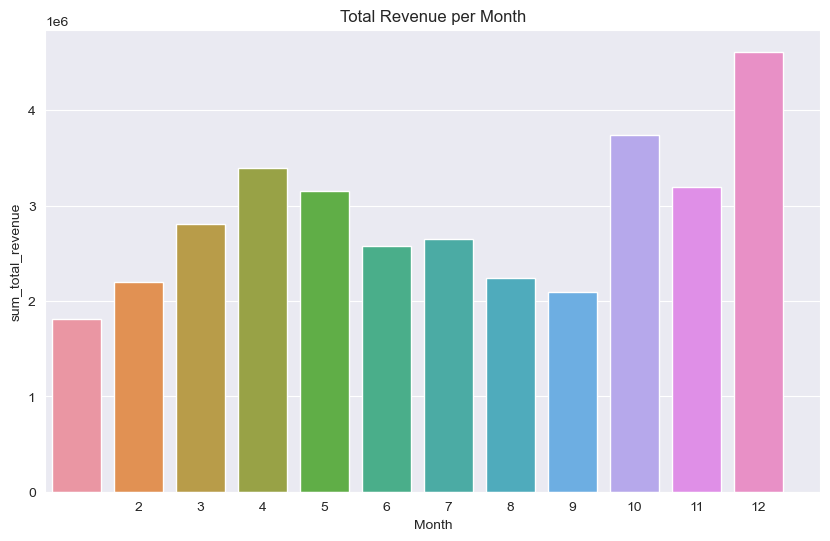

In [39]:
sum_total_rev_month_pdf = sum_total_rev_month.toPandas()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
sns.barplot(x=sum_total_rev_month_pdf.Month, y = sum_total_rev_month_pdf.sum_total_revenue)
plt.title("Total Revenue per Month")
plt.xticks(range(1,13))
plt.show()

### Best month is december

In [40]:
sales_2019_df2.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+-------------+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|total_revenue|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+-------------+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|   12|       1700.0|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|   12|        600.0|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|   12|        11.95|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...| San Francisco|   CA|   12|       149.99|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|       Atl

## City Sold Most Product in terms of Quantity

In [41]:
city_most_products = (sales_2019_df2.groupBy("City")
               .agg(count("Quantity").alias("Quantity_sum"))
               .orderBy("Quantity_sum", ascending = False))

In [42]:
city_most_products.show()

+--------------+------------+
|          City|Quantity_sum|
+--------------+------------+
| San Francisco|       44720|
|   Los Angeles|       29604|
| New York City|       24866|
|        Boston|       19930|
|       Atlanta|       14881|
|        Dallas|       14818|
|       Seattle|       14731|
|      Portland|       12463|
|        Austin|        9903|
+--------------+------------+



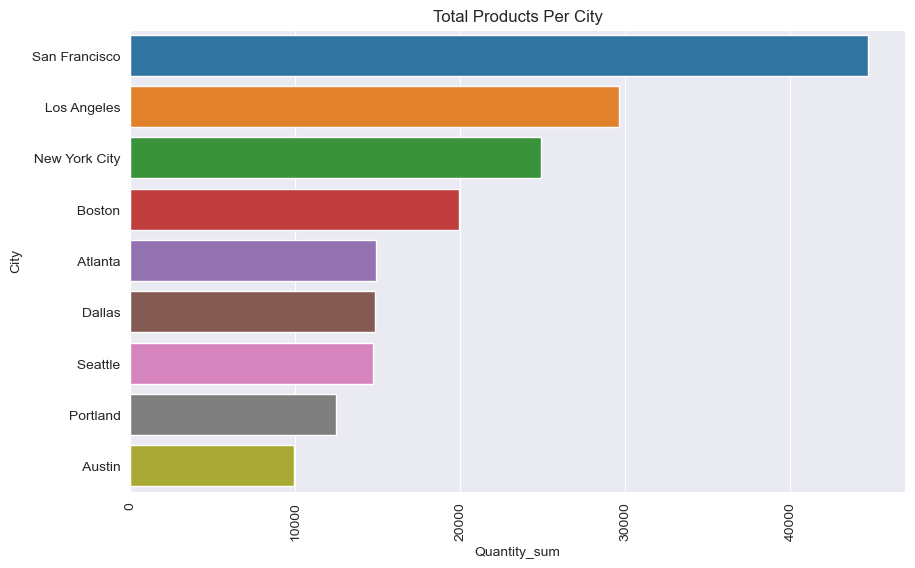

In [43]:
city_most_products_pdf = city_most_products.toPandas()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
sns.barplot(y=city_most_products_pdf.City, x= city_most_products_pdf.Quantity_sum)
plt.xticks(rotation=90)
plt.title("Total Products Per City")
plt.show()

### City with highest number of products sold is san francisco

## Question 3

- What time should we display advertisements to maximize the likelihood of customers buying products?

In [44]:
#remove duplicate order ID's so we get a bette idea of how many orders where made per hour

In [45]:
time_df = (sales_2019_df2.select("OrderID", hour(col("OrderDate")).alias("hour"))
                        .distinct().groupBy("hour")
                        .agg(count("hour").alias("TotalHours"))
                        .orderBy("TotalHours", ascending=False))

In [46]:
time_df.show(10)

+----+----------+
|hour|TotalHours|
+----+----------+
|  19|     12377|
|  12|     12082|
|  11|     11882|
|  20|     11763|
|  18|     11761|
|  13|     11682|
|  14|     10522|
|  21|     10499|
|  10|     10492|
|  17|     10476|
+----+----------+
only showing top 10 rows



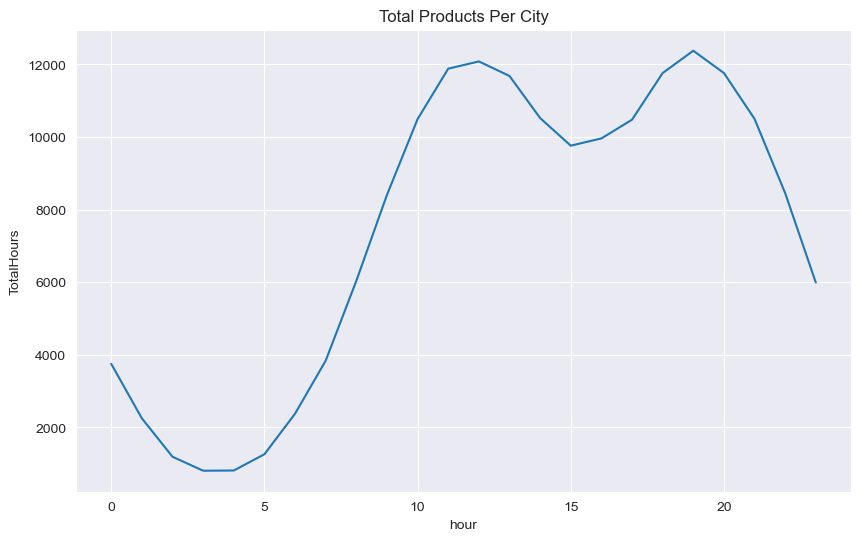

In [48]:
time_pdf = time_df.toPandas()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
sns.lineplot(x=time_pdf.hour, y= time_pdf.TotalHours)
plt.title("Total Products Per City")
plt.show()

## So the best times to display ads based on when most oders where made would be 12pm in the day and 7pm at night

## Question 4

- What products are often sold together in the state “NY”?

In [50]:
sales_2019_df.show(10,truncate=False)

+-------+--------------------------+--------+------+-------------------+-----------------------------------------+--------------+-----+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                             |City          |State|Month|
+-------+--------------------------+--------+------+-------------------+-----------------------------------------+--------------+-----+-----+
|295665 |Macbook Pro Laptop        |1       |1700.0|2019-12-30 00:01:00|136 Church St, New York City, NY 10001   | New York City|NY   |12   |
|295666 |LG Washing Machine        |1       |600.0 |2019-12-29 07:03:00|562 2nd St, New York City, NY 10001      | New York City|NY   |12   |
|295667 |USB-C Charging Cable      |1       |11.95 |2019-12-12 18:21:00|277 Main St, New York City, NY 10001     | New York City|NY   |12   |
|295668 |27in FHD Monitor          |1       |149.99|2019-12-22 15:13:00|410 6th St, San Francisco, CA 94016      | San Francisco|CA   |12   |
|29566

In [51]:
sales_2019_df.select(count_distinct(col("State"))).show()

+---------------------+
|count(DISTINCT State)|
+---------------------+
|                    8|
+---------------------+



In [55]:
sales_2019_df.where(col("State")=="NY").show(10)

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...| New York City|   NY|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...| New York City|   NY|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...| New York City|   NY|   12|
| 295670|AA Batteries (4-p...|       1|  3.84|2019-12-31 22:58:00|200 Jefferson St,...| New York City|   NY|   12|
| 295698|     Vareebadd Phone|       1| 400.0|2019-12-13 14:32:00|175 1st St, New Y...| New York City|   NY|   12|
| 295698|USB-C Charging Cable|       2| 11.95|2019-12-13 14:32:00|175 1st St, Ne

In [56]:
#narrow down to NY

Aggregated_products_df = (sales_2019_df.where(col("State")=="NY")
                                       .groupBy("OrderID")
                                       .agg(collect_list("Product").alias("Aggregated_Products")))
Aggregated_products_df.show(10,False)

+-------+----------------------------+
|OrderID|Aggregated_Products         |
+-------+----------------------------+
|141264 |[Apple Airpods Headphones]  |
|141268 |[AA Batteries (4-pack)]     |
|141272 |[AAA Batteries (4-pack)]    |
|141278 |[Lightning Charging Cable]  |
|141282 |[Vareebadd Phone]           |
|141301 |[Apple Airpods Headphones]  |
|141314 |[Macbook Pro Laptop]        |
|141317 |[27in FHD Monitor]          |
|141323 |[USB-C Charging Cable]      |
|141343 |[Bose SoundSport Headphones]|
+-------+----------------------------+
only showing top 10 rows



In [57]:
(Aggregated_products_df.groupBy("Aggregated_Products")
                      .count()
                      .where(size(col("Aggregated_Products")) > 1)
                      .orderBy("count", ascending=False)).show(truncate=False)

+------------------------------------------------------------+-----+
|Aggregated_Products                                         |count|
+------------------------------------------------------------+-----+
|[iPhone, Lightning Charging Cable]                          |126  |
|[Google Phone, USB-C Charging Cable]                        |124  |
|[Google Phone, Wired Headphones]                            |52   |
|[Vareebadd Phone, USB-C Charging Cable]                     |49   |
|[iPhone, Wired Headphones]                                  |46   |
|[iPhone, Apple Airpods Headphones]                          |43   |
|[Google Phone, Bose SoundSport Headphones]                  |23   |
|[Vareebadd Phone, Wired Headphones]                         |17   |
|[Apple Airpods Headphones, Wired Headphones]                |12   |
|[Google Phone, USB-C Charging Cable, Wired Headphones]      |11   |
|[AA Batteries (4-pack), Apple Airpods Headphones]           |10   |
|[Lightning Charging Cable, AAA Ba

### We can now see that [iPhone, Lightning Charging Cable] and [Google Phone, USB-C Charging Cable] are the most common items to be bought together